In [1]:
import numpy as np
import pandas as pd
import sklearn.ensemble
from matplotlib import pyplot as plt

## Prediction Model

In [2]:
feature_names = ["Age",
                 "Workclass",
                 "fnlwgt",
                 "Education",
                 "Education-Num",
                 "Marital Status",
                 "Occupation",
                 "Relationship",
                 "Race", "Sex",
                 "Capital Gain",
                 "Capital Loss",
                 "Hours per week",
                 "Country",
                 'Income']


In [3]:
# Utility function which works like pd.Series.apply(lambda x: map[x]), but adds additional preprocessing
def map_array_values(series, value_map):
    if series.dtype == 'object':
        ret = series.str.strip().copy()
    else:
        ret = series.copy()
    for src, target in value_map.items():
        ret[ret == src] = target
    return ret

In [4]:
# Dictionaries for feature engineering
education_map = {
    '10th': 'Dropout', '11th': 'Dropout', '12th': 'Dropout', '1st-4th':
        'Dropout', '5th-6th': 'Dropout', '7th-8th': 'Dropout', '9th':
        'Dropout', 'Preschool': 'Dropout', 'HS-grad': 'High School grad',
    'Some-college': 'High School grad', 'Masters': 'Masters',
    'Prof-school': 'Prof-School', 'Assoc-acdm': 'Associates',
    'Assoc-voc': 'Associates',
}
occupation_map = {
    "Adm-clerical": "Admin", "Armed-Forces": "Military",
    "Craft-repair": "Blue-Collar", "Exec-managerial": "White-Collar",
    "Farming-fishing": "Blue-Collar", "Handlers-cleaners":
        "Blue-Collar", "Machine-op-inspct": "Blue-Collar", "Other-service":
        "Service", "Priv-house-serv": "Service", "Prof-specialty":
        "Professional", "Protective-serv": "Other", "Sales":
        "Sales", "Tech-support": "Other", "Transport-moving":
        "Blue-Collar",
}
country_map = {
    'Cambodia': 'SE-Asia', 'Canada': 'British-Commonwealth', 'China':
        'China', 'Columbia': 'South-America', 'Cuba': 'Other',
    'Dominican-Republic': 'Latin-America', 'Ecuador': 'South-America',
    'El-Salvador': 'South-America', 'England': 'British-Commonwealth',
    'France': 'Euro_1', 'Germany': 'Euro_1', 'Greece': 'Euro_2',
    'Guatemala': 'Latin-America', 'Haiti': 'Latin-America',
    'Holand-Netherlands': 'Euro_1', 'Honduras': 'Latin-America',
    'Hong': 'China', 'Hungary': 'Euro_2', 'India':
        'British-Commonwealth', 'Iran': 'Other', 'Ireland':
        'British-Commonwealth', 'Italy': 'Euro_1', 'Jamaica':
        'Latin-America', 'Japan': 'Other', 'Laos': 'SE-Asia', 'Mexico':
        'Latin-America', 'Nicaragua': 'Latin-America',
    'Outlying-US(Guam-USVI-etc)': 'Latin-America', 'Peru':
        'South-America', 'Philippines': 'SE-Asia', 'Poland': 'Euro_2',
    'Portugal': 'Euro_2', 'Puerto-Rico': 'Latin-America', 'Scotland':
        'British-Commonwealth', 'South': 'Euro_2', 'Taiwan': 'China',
    'Thailand': 'SE-Asia', 'Trinadad&Tobago': 'Latin-America',
    'United-States': 'United-States', 'Vietnam': 'SE-Asia'
}
married_map = {
    'Never-married': 'Never-Married', 'Married-AF-spouse': 'Married',
    'Married-civ-spouse': 'Married', 'Married-spouse-absent':
        'Separated', 'Separated': 'Separated', 'Divorced':
        'Separated', 'Widowed': 'Widowed'
}

In [5]:
# Transform Capita Gain into categories - None, Low, High
def cap_gains_fn(x):
    x = x.astype(float)
    d = np.digitize(x, [0, np.median(x[x > 0]), float('inf')], right=True)
    new_series = pd.Series(["None"] * len(d))
    new_series[d == 0] = 'None'
    new_series[d == 1] = 'Low'
    new_series[d == 2] = 'High'
    return new_series

In [6]:
transformations = {
    'Education': lambda x: map_array_values(x, education_map),
    'Marital Status': lambda x: map_array_values(x, married_map),
    'Occupation': lambda x: map_array_values(x, occupation_map),
    'Capital Gain': cap_gains_fn,
    'Capital Loss': cap_gains_fn,
    'Country': lambda x: map_array_values(x, country_map),
}

In [7]:
df = pd.read_csv("../data/adult.data", header=None)
df.columns = feature_names
target_labels = pd.Series(df.iloc[:, -1], index=df.index)

features_to_use = [0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13]
df = df.iloc[:, features_to_use]

df.dropna(inplace=True)
df.head()

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [8]:
# Run feature engineering and then transformations on all features
for feature, fun in transformations.items():
    df[feature] = fun(df[feature])

In [9]:
categorical_features_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
label_encoders = {}  
for f_idx in categorical_features_idx:
    le = sklearn.preprocessing.LabelEncoder()
    df.iloc[:, f_idx] = le.fit_transform(df.iloc[:, f_idx])
    label_encoders[f_idx] = le

le = sklearn.preprocessing.LabelEncoder()
target_labels = le.fit_transform(target_labels)

In [10]:
# Split into train, and put rest aside to split later into val and test
train_X, rest_X, train_y, rest_y = sklearn.model_selection.train_test_split(df,
                                                                            target_labels,
                                                                            stratify=target_labels,
                                                                            test_size=0.5,
                                                                            random_state=42)
# Split into validation and test sets
val_X, test_X, val_y, test_y = sklearn.model_selection.train_test_split(rest_X,
                                                                        rest_y,
                                                                        stratify=rest_y,
                                                                        test_size=0.5,
                                                                        random_state=42)

In [13]:
train_npy = df.to_numpy()

In [15]:
df.head()

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,7,1,1,1,1,4,1,1,2,40,9
1,50,6,1,0,8,0,4,1,2,2,13,9
2,38,4,4,2,2,1,4,1,2,2,40,9
3,53,4,3,0,2,0,2,1,2,2,40,9
4,28,4,1,0,5,5,2,0,2,2,40,6


In [20]:
np.save('adult_X', train_npy)
np.save('adult_y', target_labels)

In [21]:
len(target_labels), len(train_npy)

(32561, 32561)

In [11]:
c = sklearn.ensemble.RandomForestClassifier(n_estimators=20, max_depth=10, n_jobs=5, random_state=42)
c.fit(train_X, train_y)

print(f'Train Accuracy: {sklearn.metrics.accuracy_score(train_y, c.predict(train_X))*100:.2f}%')
print(f'Validation Accuracy: {sklearn.metrics.accuracy_score(val_y, c.predict(val_X))*100:.2f}%')

Train Accuracy: 86.95%
Validation Accuracy: 85.48%


In [12]:
# Save model
import joblib
joblib.dump(c, "../model/classification_model.joblib")

['../model/classification_model.joblib']

## Monitoring Model

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(np.array(df, dtype="float"), test_size=0.2)

### Train 

In [14]:
from pyod.models.knn import KNN
monitoring_model = KNN(contamination=0.05, n_neighbors=15, p = 5)
monitoring_model.fit(X_train)

KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=15, p=5,
  radius=1.0)

In [15]:
y_train_pred = monitoring_model.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = monitoring_model.decision_scores_  # raw outlier scores

# Get the prediction on the test data
y_test_pred = monitoring_model.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = monitoring_model.decision_function(X_test)  # outlier scores

### Check for overfitting

Check that outlier classsifier did not overfit and that train and test score distributions match each other

In [21]:
df.columns

Index(['Age', 'Workclass', 'Education', 'Marital Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Country'],
      dtype='object')

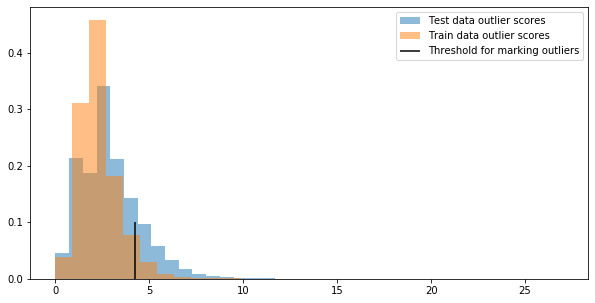

In [16]:
plt.hist(y_test_scores, bins=30, alpha=0.5, density=True, label="Test data outlier scores")
plt.hist(y_train_scores, bins=30, alpha=0.5, density=True, label="Train data outlier scores")

plt.vlines(monitoring_model.threshold_, 0, 0.1, label = "Threshold for marking outliers")

plt.gcf().set_size_inches(10, 5)
_ = plt.legend()

In [17]:
# save monitoring model
import joblib
joblib.dump(monitoring_model, "../monitoring_model/monitoring_model.joblib")

['../monitoring_model/monitoring_model.joblib']